### Structure
- Data loading, cleaning and preprocessing
- Dividing data into features, labels and test data
- Tokenizing words
- Baseline model
- Advanced model using fasttext
- Evaluate, testing with F1, precision, recall and confusion matrix
- Predict on a few sentences with output
- Appendix: Hypertuning grid search method

In [ ]:
!pip install emoji
!pip install pyarabic
!pip install gensim
!pip install fasttext

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4498214 sha256=9827c75907ad8cf404cbba9afb570b8ab5260dfc6c3b31c2c60134ace3ca3914
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


In [ ]:
import pandas as pd
import numpy as np
import re
import emoji
import pyarabic.araby as araby
import io

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Conv1D, Dropout, Dense, GlobalMaxPooling1D, SpatialDropout1D, GRU, GlobalAveragePooling1D, Input, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

from gensim.models import Word2Vec, KeyedVectors

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

### Connecting to Google Drive and loading the Let-mi and ArMI datasets

In [ ]:
# Connecting to my google drive as the dataset is on my drive.
# You will have to request the dataset from the original authors
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
armi_dataset = '/content/drive/My Drive/final-project/ArMI2021_training.tsv'
letmi_dataset = '/content/drive/My Drive/final-project/let-mi_train_part.csv'

armi_test_features_dataset = '/content/drive/My Drive/final-project/ArMI2021_test.tsv'
armi_test_label_dataset = '/content/drive/My Drive/final-project/ArMI2021_gold.tsv'

df_armi = pd.read_csv(armi_dataset, sep='\t')
df_armi_test_features = pd.read_csv(armi_test_features_dataset, sep='\t')
df_armi_test_label = pd.read_csv(armi_test_label_dataset, sep='\t')
df_letmi = pd.read_csv(letmi_dataset)

### Data preprocessing
- extract the text and misogyny columns from both datasets
- concat both datasets into one unified dataset
- Convert the values in misogyny column to 1 and 0
- Same thing to the test dataset

In [ ]:
# Get only text and misogyny from datasets
df_armi = df_armi[['text', 'misogyny']]
df_letmi = df_letmi[['text', 'misogyny']]

# Concat both let-mi and ArMI into one dataset
df = pd.concat([df_armi, df_letmi])

# Now I am doing the same thing on the testing dataset that I got from ArMI
df_armi_test_features = df_armi_test_features[['text']]
df_armi_test_label = df_armi_test_label[['misogyny']]

# Convert misogyny from 'none' and 'misogyny' to 0 and 1
df['misogyny'] = (df['misogyny'] == 'misogyny').astype(int);
df_armi_test_label['misogyny'] = (df_armi_test_label['misogyny'] == 'misogyny').astype(int);

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13106 entries, 0 to 5239
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      13106 non-null  object
 1   misogyny  13106 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 307.2+ KB


### Data cleaning
This function will clean the data of both my training and testing datasets, it will be also used to clean the text that I will use to predict as a final experiment at the end. Details of this function are below in comments

In [ ]:
def data_cleaning(text):

  # For any foreign language or for links
  text = text.lower()

  # Removing all mentions with @
  text = re.sub(r"@\w+", '', text)

  # Remove all links
  text = re.sub(r'https?:\/\/.*[\r\n]*', "", text, flags=re.MULTILINE)

  # These are some issues that couldnt be removed so I had to manually force remove them
  for char in ["مستخدم@", "#", "…", "RT", "\ufffd"]:
    text = text.replace(char, "")

  # Convert exclamation point and question mark into words, to give them more weight in the context
  text = re.sub(r'!+', ' [EXCLAMATION] ', text)
  text = re.sub(r'\?+', ' [QUESTION] ', text)

  # Removed some useless characters
  chars_to_remove = r'[!"#$%&\'()*+,-./:;<=>?@\[\\\]^_`{|}~،؛؟ـ٪٫٬«»“”•·…﴾﴿〈〉°±÷×©®™€£¥¢]'
  text = re.sub(chars_to_remove, ' ', text)

  # I am keeping everything on one line
  text = re.sub(r'[\r\n]+', ' ', text)

  # Normalizing some letters to unify some words and match more words
  text = re.sub("[إأآا]", "ا", text)
  text = re.sub("ى", "ي", text)
  text = re.sub("ؤ", "ء", text)
  text = re.sub("ئ", "ء", text)
  text = re.sub("ة", "ه", text)
  text = re.sub("گ", "ك", text)

  # Remove extra spaces
  text = re.sub(r'\s+', ' ', text)

  # This is for underscores inside hashtags, so I am converting the hashtag into words
  text = text.replace("_", " ")

  # Since I dont have much data, I am converting emojis into text to also give more context to sentences
  text = emoji.demojize(text, delimiters=(" ", " "))

  # strip tashkeel and tatweel
  text = araby.strip_tashkeel(text)
  text = araby.strip_tatweel(text)

  text = text.strip()
  return text

In [ ]:
df['text'] = df['text'].apply(data_cleaning)
df_armi_test_features['text'] = df_armi_test_features['text'].apply(data_cleaning)

In [ ]:
# Put everything into X_train, y_train, X_test and y_text so it will be easier for me to work with
X_train = df['text']
y_train = df['misogyny']
X_test = df_armi_test_features['text']
y_test = df_armi_test_label['misogyny']

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13106,), (13106,), (1967,), (1967,))

In [ ]:
# Top 10k most frequent words
max_words = 10000

# mean is 11 and 95 percentile is 113, so there is a big gap between sentences, I went with 48 as a middle ground
max_len = 48

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

### Baseline model
This baseline without any pretrained or libraries

In [ ]:
model = Sequential([
    # Input Layer
    Embedding(max_words, 128, input_shape=(max_len,)),

    # CNN Layer
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(keepdims=True),

    # LSTM Layers
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),

    # Dense Layers
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ (None, 48, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 44, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_25         │ (None, 1, 64)          │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_31                │ (None, 1, 128)         │        66,048 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ (None, 64)             │        41,216 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,429,345 (5.45 MB)

 Trainable params: 1,429,345 (5.45 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train_seq, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.6317 - loss: 0.6057 - val_accuracy: 0.9169 - val_loss: 0.2015
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.9368 - loss: 0.1776 - val_accuracy: 0.9802 - val_loss: 0.0559
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9861 - loss: 0.0559 - val_accuracy: 0.9920 - val_loss: 0.0242
Epoch 4/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9943 - loss: 0.0280 - val_accuracy: 0.9943 - val_loss: 0.0131
Epoch 5/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.9956 - loss: 0.0159 - val_accuracy: 0.9962 - val_loss: 0.0101
Epoch 6/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9987 - loss: 0.0104 - val_accuracy: 0.9981 - val_loss: 0.0041
Epoch 7/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9981 - loss: 0.0078 - val_accuracy: 0.9962 - val_loss: 0.0107
Epoch 8/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9964 - loss: 0.0213 - val_accu

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4611 - loss: 6.4509

Test Accuracy: 46.31%


### Advanced model using fasttext
Next, I will create a more advanced model using [fasttext](https://fasttext.cc/docs/en/crawl-vectors.html) (n-grams) and the arabic vector file to create a better embedding matrix.

Since I am working with Google Colab, I will let the instance download and unzip the file directly.

In [ ]:
# Download the Arabic vectors (compressed .gz file)
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz

# Decompress the file
!gunzip cc.ar.300.vec.gz

# Check if the file is there
!ls -lh cc.ar.300.vec

--2025-12-19 17:49:42--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.143.109, 13.225.143.99, 13.225.143.122, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.143.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz’

cc.ar.300.vec.gz    100%[===================>]   1.18G   236MB/s    in 11s     

2025-12-19 17:49:53 (114 MB/s) - ‘cc.ar.300.vec.gz’ saved [1272365870/1272365870]

-rw-r--r-- 1 root root 4.3G Jan 18  2019 cc.ar.300.vec


In [ ]:
def load_fasttext_vectors(fname, word_index, max_words):
    # Read the .vec file that we just downloaded
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())

    # Initialize matrix
    embedding_matrix = np.zeros((max_words, d))

    for line in fin:
        tokens = line.rstrip().split(' ')
        word = tokens[0]
        if word in word_index:
            idx = word_index[word]
            if idx < max_words:
                embedding_matrix[idx] = np.array(tokens[1:], dtype='float32')
    return embedding_matrix

# Get the embedding matrix
embedding_matrix = load_fasttext_vectors('cc.ar.300.vec', tokenizer.word_index, max_words)

In [ ]:
# Input Layer, using an embedding dim of 300 and the embedding matric we created above, and max len of 48
input_layer = Input(shape=(max_len,))
x = Embedding(max_words, 300, weights=[embedding_matrix], input_shape=(max_len,), trainable=False)(input_layer)

x = SpatialDropout1D(0.4)(x)

# CNN Layer
x = Conv1D(128, 5, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)

# GRU Layers
x = Bidirectional(GRU(64, return_sequences=True))(x) # Pass to pooling

avg_pool = GlobalAveragePooling1D()(x)
max_pool = GlobalMaxPooling1D()(x)
merged = concatenate([avg_pool, max_pool])

# Dense Layers
x = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(merged)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

my_model = Model(inputs=input_layer, outputs=output)

my_model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:100: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
my_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 48, 300)   │  3,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 48, 300)   │          0 │ embedding[0][0]   │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 44, 128)   │    192,128 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 44, 128)   │     74,496 │ conv1d[0][0]      │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     16,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,283,137 (12.52 MB)

 Trainable params: 283,137 (1.08 MB)

 Non-trainable params: 3,000,000 (11.44 MB)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("my_model.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        restore_best_weights=True,
        patience=5,
        verbose=1,
        mode="max"
    )
]

history = my_model.fit(
    X_train_seq, y_train,
    epochs=100,              # Set a high number, EarlyStopping will cut it short
    batch_size=32,
    validation_split=0.2,   # Use 20% of training data for validation
    callbacks=[callbacks]
)

Epoch 1/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.5837 - loss: 0.9251 - val_accuracy: 0.6937 - val_loss: 0.7938
Epoch 2/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.7300 - loss: 0.7346 - val_accuracy: 0.7590 - val_loss: 0.6600
Epoch 3/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7600 - loss: 0.6561 - val_accuracy: 0.7822 - val_loss: 0.6076
Epoch 4/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7691 - loss: 0.6174 - val_accuracy: 0.8085 - val_loss: 0.5653
Epoch 5/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7772 - loss: 0.5840 - val_accuracy: 0.8299 - val_loss: 0.5294
Epoch 6/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7887 - loss: 0.5518 - val_accuracy: 0.8360 - val_loss: 0.5022
Epoch 7/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8016 - loss: 0.5330 - val_accuracy: 0.8242 - val_loss: 0.5089
Epoch 8/100
328/328 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8103 - loss: 0.5112 -

In [ ]:
# Evaluate model
test_loss, test_acc = my_model.evaluate(X_test_seq, y_test)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8140 - loss: 0.6220

Test Accuracy: 83.22%


### Evaluate, testing with F1, precision, recall and confusion matrix
Next we will evaluate our models and run some tests

In [ ]:
y_pred_probs = my_model.predict(X_test_seq)
y_pred = (y_pred_probs > 0.5).astype("int32")
print(classification_report(y_test, y_pred))

# Precision
precision = precision_score(y_test, y_pred)

# Recall
recall = recall_score(y_test, y_pred)

# F1 score
f1 = f1_score(y_test, y_pred)

print(f"Corrected Precision: {precision:.4f}")
print(f"Corrected Recall: {recall:.4f}")
print(f"Corrected F1-score: {f1:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

           0       0.77      0.81      0.79       766
           1       0.88      0.84      0.86      1201

    accuracy                           0.83      1967
   macro avg       0.82      0.83      0.83      1967
weighted avg       0.83      0.83      0.83      1967

Corrected Precision: 0.8771
Corrected Recall: 0.8435
Corrected F1-score: 0.8599


#### Confusion matrix

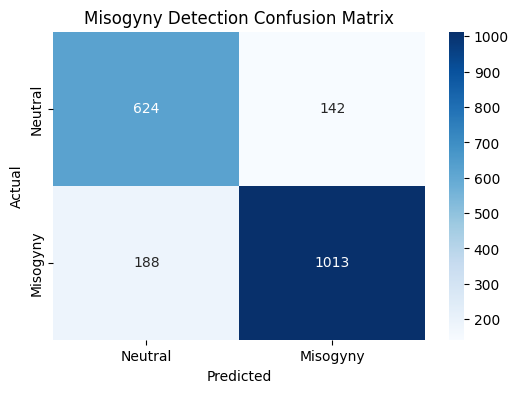

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Misogyny'], yticklabels=['Neutral', 'Misogyny'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Misogyny Detection Confusion Matrix')
plt.show()

### Predict on a few sentences with output
I will run a small final test with a few sentence and let the model output the results of its predictions

In [ ]:
test_tweets = [
    # Misogynistic (Class 1)
    "المرأة مكانها المطبخ ولا يجب أن تشارك في القرارات السياسية", # Traditional sexism
    "يا فاشلة روحي اهتمي ببيتك أحسن من الصحافة",               # Professional dismissal
    "النساء لا يمتلكن القدرة العقلية للقيادة، هن عاطفيات جداً", # Biological fallacy
    "انتي مجرد وجه جميل ولا تفهمين شيئاً في هذا العلم",        # Intellectual belittling
    "اسكتي يا بنت، الرجال هم من يتكلمون هنا",                 # Direct silencing

    # Polite / Neutral (Class 0)
    "تحية لكل امرأة عربية تكافح من أجل مستقبل وطنها",          # Empowerment
    "الصحافة مهنة صعبة تتطلب الشجاعة من الجميع",              # Neutral professional
    "يجب علينا احترام وجهات النظر المختلفة في هذا النقاش",      # Neutral debate
    "شكراً لكِ على هذا المقال الرائع والمفيد جداً",              # Appreciation
    "التعليم هو السلاح الأقوى لتغيير المجتمعات العربية"          # General social
]


def predict_misogyny(sentences, model, tokenizer, max_len):
    # Clean the sentences
    cleaned_sentences = [data_cleaning(s) for s in sentences]

    # Tokenize and Pad
    sequences = tokenizer.texts_to_sequences(cleaned_sentences)
    padded = pad_sequences(sequences, maxlen=max_len)

    # Predict
    predictions = my_model.predict(padded)

    # Output
    for i, prob in enumerate(predictions):
        label = "MISOGYNY (1)" if prob > 0.5 else "NEUTRAL (0)"
        confidence = prob[0] if prob > 0.5 else 1 - prob[0]
        print(f"Tweet: {sentences[i]}")
        print(f"Result: {label} | Confidence: {confidence*100:.2f}%\n")

predict_misogyny(test_tweets, my_model, tokenizer, 48)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Tweet: المرأة مكانها المطبخ ولا يجب أن تشارك في القرارات السياسية
Result: MISOGYNY (1) | Confidence: 98.48%

Tweet: يا فاشلة روحي اهتمي ببيتك أحسن من الصحافة
Result: MISOGYNY (1) | Confidence: 99.80%

Tweet: النساء لا يمتلكن القدرة العقلية للقيادة، هن عاطفيات جداً
Result: NEUTRAL (0) | Confidence: 86.07%

Tweet: انتي مجرد وجه جميل ولا تفهمين شيئاً في هذا العلم
Result: MISOGYNY (1) | Confidence: 81.28%

Tweet: اسكتي يا بنت، الرجال هم من يتكلمون هنا
Result: MISOGYNY (1) | Confidence: 76.43%

Tweet: تحية لكل امرأة عربية تكافح من أجل مستقبل وطنها
Result: NEUTRAL (0) | Confidence: 99.94%

Tweet: الصحافة مهنة صعبة تتطلب الشجاعة من الجميع
Result: NEUTRAL (0) | Confidence: 98.64%

Tweet: يجب علينا احترام وجهات النظر المختلفة في هذا النقاش
Result: NEUTRAL (0) | Confidence: 94.96%

Tweet: شكراً لكِ على هذا المقال الرائع والمفيد جداً
Result: NEUTRAL (0) | Confidence: 99.86%

Tweet: التعليم هو السلاح الأقوى لتغيير المجتمعات العربية
Result: NEUTRAL (0) | Confi

### Appendix: Hypertuning grid search method

This is the function I used to run a grid search for finding the best hyperparameter

In [ ]:
import pandas as pd

learning_rates = [1e-3, 1e-4]
dropout_rates = [0.3, 0.5]
batch_sizes = [16, 32]

results = []

for lr in learning_rates:
    for dr in dropout_rates:
        for bs in batch_sizes:
            print(f"Testing: LR={lr}, Dropout={dr}, Batch={bs}")

            input_layer = Input(shape=(max_len,))
            x = Embedding(max_words, 300, weights=[embedding_matrix], trainable=False)(input_layer)
            x = SpatialDropout1D(dr)(x)
            x = Conv1D(128, 5, activation='relu')(x)
            x = Bidirectional(GRU(64, return_sequences=True))(x)
            avg_pool = GlobalAveragePooling1D()(x)
            max_pool = GlobalMaxPooling1D()(x)
            merged = concatenate([avg_pool, max_pool])
            x = Dense(32, activation='relu')(merged)
            x = Dropout(dr)(x)
            output = Dense(1, activation='sigmoid')(x)

            m = Model(inputs=input_layer, outputs=output)
            m.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])

            h = m.fit(X_train_seq, y_train,
                      validation_split=0.2,
                      epochs=30,
                      batch_size=bs,
                      callbacks=[EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)],
                      verbose=0)

            _, acc = m.evaluate(X_test_seq, y_test, verbose=0)
            print(f"Final Test Accuracy: {acc:.4f}")

            results.append({'lr': lr, 'dropout': dr, 'batch': bs, 'accuracy': acc})

rdf = pd.DataFrame(results).sort_values(by='accuracy', ascending=False)
print(rdf)

Testing: LR=0.001, Dropout=0.3, Batch=16
Final Test Accuracy: 0.8246
Testing: LR=0.001, Dropout=0.3, Batch=32
Final Test Accuracy: 0.8302
Testing: LR=0.001, Dropout=0.5, Batch=16
Final Test Accuracy: 0.8165
Testing: LR=0.001, Dropout=0.5, Batch=32
Final Test Accuracy: 0.8353
Testing: LR=0.0001, Dropout=0.3, Batch=16
Final Test Accuracy: 0.8317
Testing: LR=0.0001, Dropout=0.3, Batch=32
Final Test Accuracy: 0.8221
Testing: LR=0.0001, Dropout=0.5, Batch=16
Final Test Accuracy: 0.8327
Testing: LR=0.0001, Dropout=0.5, Batch=32
Final Test Accuracy: 0.8353
       lr  dropout  batch  accuracy
3  0.0010      0.5     32  0.835282
7  0.0001      0.5     32  0.835282
6  0.0001      0.5     16  0.832740
4  0.0001      0.3     16  0.831723
1  0.0010      0.3     32  0.830198
0  0.0010      0.3     16  0.824606
5  0.0001      0.3     32  0.822064
2  0.0010      0.5     16  0.816472
